In [1]:
!sudo add-apt-repository ppa:deadsnakes/ppa -y
!sudo apt-get update -y
!sudo apt-get install python3.12 python3.12-venv python3.12-dev -y
!sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.10 1
!sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.12 2
!sudo update-alternatives --set python3 /usr/bin/python3.12
!python3 -m ensurepip
!python3 -m pip install --upgrade pip
!python -V

Repository: 'deb https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu/ jammy main'
Description:
This PPA contains more recent Python versions packaged for Ubuntu.

Disclaimer: there's no guarantee of timely updates in case of security problems or other issues. If you want to use them in a security-or-otherwise-critical environment (say, on a production server), you do so at your own risk.

Update Note
Please use this repository instead of ppa:fkrull/deadsnakes.

Reporting Issues

Issues can be reported in the master issue tracker at:
https://github.com/deadsnakes/issues/issues

Supported Ubuntu and Python Versions

- Ubuntu 20.04 (focal) Python3.5 - Python3.7, Python3.9 - Python3.13
- Ubuntu 22.04 (jammy) Python3.7 - Python3.9, Python3.11 - Python3.13
- Ubuntu 24.04 (noble) Python3.7 - Python3.11, Python3.13
- Note: Python2.7 (focal, jammy), Python 3.8 (focal), Python 3.10 (jammy), Python3.12 (noble) are not provided by deadsnakes as upstream ubuntu provides those packages.

Why some

In [5]:
import os
import math

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import yfinance as yf

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [28]:
TICKER = 'ETH-USD'
PERIOD = '1y'
INTERVAL = '1h'

df = yf.download(TICKER, period=PERIOD, interval=INTERVAL)
df = df[['Close']].dropna()

scaler = MinMaxScaler(feature_range=(0, 1))
values = scaler.fit_transform(df.values)

WINDOW_SIZE = 60
HORIZON = 12

X, y = [], []
for i in range(len(values) - WINDOW_SIZE - HORIZON + 1):
    X.append(values[i : i + WINDOW_SIZE])
    y.append(values[i + WINDOW_SIZE : i + WINDOW_SIZE + HORIZON].flatten())

X = np.array(X)
y = np.array(y)

split_idx = int(0.8 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).float()
X_test_tensor  = torch.from_numpy(X_test).float()
y_test_tensor  = torch.from_numpy(y_test).float()

[*********************100%***********************]  1 of 1 completed


In [29]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

batch_size = 64

train_dataset = TimeSeriesDataset(X_train_tensor, y_train_tensor)
test_dataset  = TimeSeriesDataset(X_test_tensor,  y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

In [30]:
class TransformerEncoderLayerCustom(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward, dropout):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        self.linear1  = nn.Linear(d_model, dim_feedforward)
        self.linear2  = nn.Linear(dim_feedforward, d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.norm1    = nn.LayerNorm(d_model)
        self.norm2    = nn.LayerNorm(d_model)

    def forward(self, src):
        # src: (seq_len, batch, d_model)
        attn_output, attn_weights = self.self_attn(src, src, src,
                                                  need_weights=True,
                                                  average_attn_weights=False)
        src = src + self.dropout1(attn_output)
        src = self.norm1(src)

        ff = self.linear2(self.dropout2(F.relu(self.linear1(src))))
        src = src + ff
        src = self.norm2(src)
        return src, attn_weights  # attn_weights: (batch, seq_len, seq_len)

class TimeSeriesTransformer(nn.Module):
    def __init__(self,
                 input_dim=1,
                 d_model=64,
                 nhead=4,
                 num_layers=3,
                 dim_feedforward=128,
                 dropout=0.1,
                 window_size=WINDOW_SIZE,
                 horizon=HORIZON):
        super().__init__()
        self.d_model = d_model
        self.window_size = window_size
        self.horizon = horizon

        self.input_proj = nn.Linear(input_dim, d_model)
        self.positional_encoding = nn.Parameter(torch.zeros(1, window_size, d_model))

        # Слои
        self.layers = nn.ModuleList([
            TransformerEncoderLayerCustom(d_model, nhead, dim_feedforward, dropout)
            for _ in range(num_layers)
        ])

        # Декодер — регрессор из последнего состояния
        self.decoder = nn.Linear(d_model, horizon)

        nn.init.xavier_uniform_(self.input_proj.weight)
        nn.init.constant_(self.input_proj.bias, 0.)
        nn.init.xavier_uniform_(self.decoder.weight)
        nn.init.constant_(self.decoder.bias, 0.)

    def forward(self, x):
        # x: (batch, window_size, input_dim)
        batch_size, seq_len, _ = x.size()

        # Проекция и масштаб
        x = self.input_proj(x) * math.sqrt(self.d_model)
        # Добавляем позиционное кодирование
        x = x + self.positional_encoding[:, :seq_len, :]

        # Переводим в форму (seq_len, batch, d_model)
        x = x.permute(1, 0, 2)

        # Прогоняем по слоям, сохраняем attention
        attn_weights_all = []
        for layer in self.layers:
            x, attn = layer(x)
            attn_weights_all.append(attn)

        last_hidden = x[-1]  # (batch, d_model)
        out = self.decoder(last_hidden)  # (batch, horizon)

        return out, attn_weights_all

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TimeSeriesTransformer().to(device)

In [31]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 15

train_losses = []
test_losses  = []

for epoch in range(1, num_epochs+1):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        preds, _ = model(X_batch)
        loss = criterion(preds, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X_batch.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            preds, _ = model(X_batch)
            val_loss += criterion(preds, y_batch).item() * X_batch.size(0)
    val_loss /= len(test_loader.dataset)
    test_losses.append(val_loss)

    print(f'Epoch {epoch:02d} — Train Loss: {epoch_loss:.6f}  |  Val Loss: {val_loss:.6f}')

Epoch 01 — Train Loss: 0.083404  |  Val Loss: 0.071827
Epoch 02 — Train Loss: 0.009576  |  Val Loss: 0.003812
Epoch 03 — Train Loss: 0.004578  |  Val Loss: 0.001018
Epoch 04 — Train Loss: 0.002818  |  Val Loss: 0.000938
Epoch 05 — Train Loss: 0.002099  |  Val Loss: 0.000564
Epoch 06 — Train Loss: 0.001643  |  Val Loss: 0.000655
Epoch 07 — Train Loss: 0.001417  |  Val Loss: 0.000533
Epoch 08 — Train Loss: 0.001319  |  Val Loss: 0.000564
Epoch 09 — Train Loss: 0.001278  |  Val Loss: 0.000515
Epoch 10 — Train Loss: 0.001117  |  Val Loss: 0.000519
Epoch 11 — Train Loss: 0.001071  |  Val Loss: 0.000739
Epoch 12 — Train Loss: 0.001152  |  Val Loss: 0.000606
Epoch 13 — Train Loss: 0.001018  |  Val Loss: 0.000734
Epoch 14 — Train Loss: 0.001070  |  Val Loss: 0.000830
Epoch 15 — Train Loss: 0.000921  |  Val Loss: 0.000450


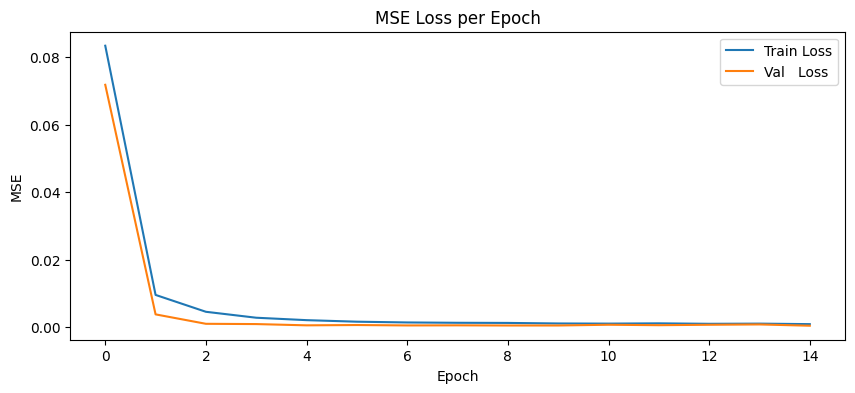

In [32]:
plt.figure(figsize=(10,4))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses,  label='Val   Loss')
plt.title('MSE Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()

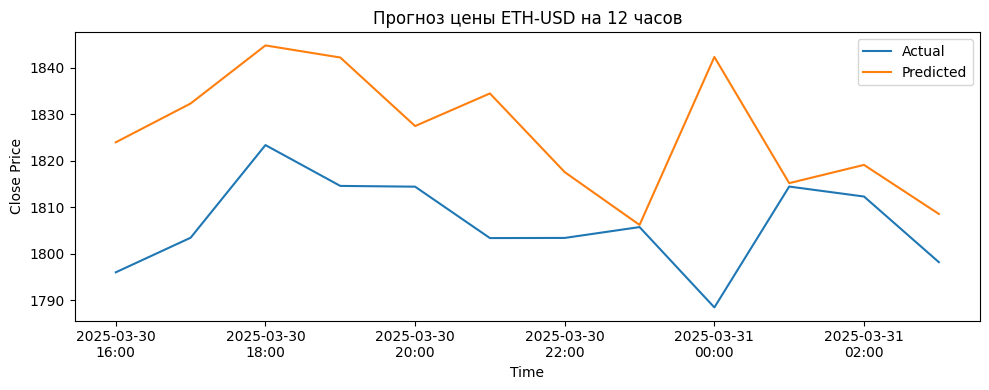

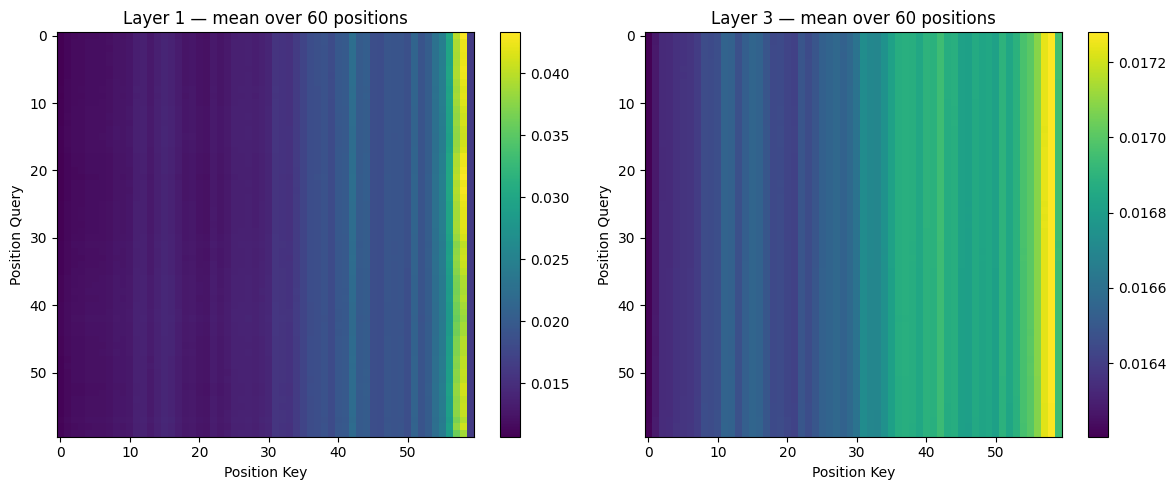

In [34]:
model.eval()
with torch.no_grad():
    x_sample = X_test_tensor[0:1].to(device)
    y_true_scaled = y_test_tensor[0].numpy()  # (HORIZON,)
    preds_scaled, attn_weights = model(x_sample)
    preds_scaled = preds_scaled.cpu().numpy().flatten()

y_true = scaler.inverse_transform(y_true_scaled.reshape(-1,1)).flatten()
y_pred = scaler.inverse_transform(preds_scaled.reshape(-1,1)).flatten()

start_idx = split_idx + WINDOW_SIZE
times = df.index[start_idx : start_idx + HORIZON]

# График прогноза vs реального
plt.figure(figsize=(10,4))
plt.plot(times, y_true, label='Actual')
plt.plot(times, y_pred, label='Predicted')
plt.title('Прогноз цены ETH-USD на 12 часов')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d\n%H:%M'))
plt.legend()
plt.tight_layout()
plt.show()

# Визуализация внимания: первый и последний слой
fig, axes = plt.subplots(1, 2, figsize=(12,5))
layer_idxs = [0, len(attn_weights)-1]
for ax, li in zip(axes, layer_idxs):
    # attn_weights[li]: тензор (batch=1, num_heads, seq, seq)
    # усредняем по головам, берём batch=0 → получаем (seq, seq)
    aw = attn_weights[li][0].mean(dim=0).cpu().numpy()
    im = ax.imshow(aw, aspect='auto')
    ax.set_title(f'Layer {li+1} — mean over {aw.shape[0]} positions')
    ax.set_xlabel('Position Key')
    ax.set_ylabel('Position Query')
    fig.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()

Выводы

1.	Динамика обучающей и валидационной потерь

  •	Уже после первой эпохи MSE на трейне резко падает с 0.08 до 0.01, валидационная ошибка сопутствует (0.07->0.003).

  •	К 5–6-й эпохе обе кривые сходятся и почти не меняются, что говорит о быстром захвате основной закономерности в данных и выходе на «плато».

  •	Небольшой разрыв между train и val в первые эпохи говорит о некрупном начальном переобучении, но к финалу модели потери практически совпадают.
2.	Качество 12-часового прогноза

  •	В целом модель правильно улавливает направление и полуколебательные тренды цены: подъём в первой половине окна, затем лёгкий спад и последующий подъём.

  •	Тем не менее видна некоторая систематическая переоценка: предсказанные значения оказываются выше реальных на 5–15 USD.

  •	Модель плохо отреагировала на резкий «провал» около 00:00 (когда реальная цена упала примерно на 25 USD), зато достаточно точно восстановила рост сразу после него.
3.	Интерпретация self-attention

  •	На первом слое (Layer 1) среднее внимание сосредоточено почти равномерно по всему окну, с лёгким доминированием последних позиций (часы 55–60).

  •	На третьем, более «глубоком» слое, веса внимания ещё сильнее смещаются вправо, то есть модель при формировании последнего скрытого вектора опирается преимущественно на последние 10–15 шагов.

  •	Такая эволюция (от равномерного внимания к фокусировке на недавних точках) хорошо коррелирует с идеей автокорреляции в финансовых рядах: самые свежие данные оказываются наиболее информативными.
4.	Сильные стороны модели

  •	Быстрое обучение (невысокая цена вычисления даже на CPU/GPU) и стабильная сходимость.

  •	Гибкость структуры — легко менять число слоёв, голов и размер дэмодели.

  •	Наглядность благодаря attention-визуализации: можно понимать, на какие исторические моменты «смотрит» модель.
5.	Идеи для улучшения

  •	Калибровка шкалы: заметная смещённость прогнозов вверх может быть скорректирована введением bias-терминов или дополнительных нормализаций/отрицательной обратной связи.

  •	Увеличение объёма данных: годовой период может быть недостаточен для уловки сезонных эффектов, стоит добавить несколько лет истории или более частые трейдинговые интервалы.

  •	Гиперпараметры: попробовать большее число голов/слоёв, увеличить dim_feedforward, поиграться с learning rate или регуляризацией (Dropout, weight decay).

  •	Мультивариантный ввод: добавить объём торгов (Volume), данные bid-ask spread, индикаторы (скользящие средние, RSI) и даже новости из соцсетей.